# Quadrotor (aka "the drone")

Import modules and configure the notebook.

In [1]:
# import required libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import ae353_drone
import sympy as sym
import numpy as np
import importlib
from scipy import linalg
from numpy import linalg as linalg1
importlib.reload(ae353_drone)

pybullet build time: Sep 12 2022 21:19:41


<module 'ae353_drone' from '/Users/ganesh/Desktop/AE353DesignProject3/code/ae353_drone.py'>

## Synthesize Linearized System Model

### Derive EOM

In [2]:
# copy from DeriveEOM notebook

m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

In [3]:
# get f

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)

In [4]:
# think about what g should be.
    # y = g(x), i.e., g should be the relation between state and output. What if output is directly some of the states?
    # what is the dimension of g? i.e., how many equations in g if say y is 6x1?

# get g
g = sym.Matrix([[p_x],[p_y],[p_z],[phi],[theta],[psi]])

### Linearize - Get A, B, C, D matrices

In [5]:
# pick equilibrium values
pxe = 0
pye = 0
pze = 0
phie = 0
thetae = 0
psie = 0
vxe = 0
vye = 0 
vze = 0
wxe = 0
wye =0
wze =0 
tauxe = 0
tauye = 0
tauze = 0 
fze = 4.905

In [6]:
# Get A matrix
A = f.jacobian([p_x,p_y,p_z,phi,theta,psi,v_x,v_y,v_z,w_x,w_y,w_z])
A_eval = A.evalf(subs={p_x:pxe,p_y:pye,p_z:pze,phi:phie,psi:psie,theta:thetae,v_x:vxe,v_y:vye,v_z:vze,tau_x:tauxe,tau_y:tauye,tau_z:tauze,f_z:fze,w_x:wxe,w_y:wye,w_z:wze})
A_nume = np.array(A_eval).astype(np.float64)
# do jacobian of f and substitute the eq values
#print(f'Dimensions of A matrix is: {np.shape(A)}')

# Get B
B = f.jacobian([tau_x,tau_y,tau_z,f_z])
B_eval = B.evalf(subs={p_x:pxe,p_y:pye,p_z:pze,phi:phie,psi:psie,theta:thetae,v_x:vxe,v_y:vye,v_z:vze,tau_x:tauxe,tau_y:tauye,tau_z:tauze,f_z:fze,w_x:wxe,w_y:wye,w_z:wze})
B_nume = np.array(B_eval).astype(np.float64)
A_eval

Matrix([
[0, 0, 0,     0,    0, 0, 1.0,   0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0, 1.0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0, 1.0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0, 1.0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0, 1.0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0,   0, 1.0],
[0, 0, 0,     0, 9.81, 0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, -9.81,    0, 0,   0,   0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0,   0,   0],
[0, 0, 0,     0,    0, 0,   0,   0,   0,   0,   0,   0]])

In [7]:
# Get C matrix
C =  g.jacobian([p_x,p_y,p_z,phi,theta,psi,v_x,v_y,v_z,w_x,w_y,w_z])
C_eval = C.evalf(subs={p_x:pxe,p_y:pye,p_z:pze,phi:phie,psi:psie,theta:thetae,v_x:vxe,v_y:vye,v_z:vze,tau_x:tauxe,tau_y:tauye,tau_z:tauze,f_z:fze,w_x:wxe,w_y:wye,w_z:wze})
C_nume = np.array(C_eval).astype(np.float64) 
C_nume
# do jacobian of g and substitute the eq values
#print(f'Dimensions of C matrix is: {np.shape(C)}')

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

### Verify Controllability and Observability

In [8]:
#  check controllability
n = A_nume.shape[0]
W = B_nume
for i in range(1,n):
    column = np.linalg.matrix_power(A_nume,i)@B_nume
    W = np.block([W,column])
    
rank = np.linalg.matrix_rank(W)
print(rank)
print(A.shape)

12
(12, 12)


In [9]:
# check observability

O = C_nume.T
for i in range(1,n):
    column = (C_nume@np.linalg.matrix_power(A_nume,i)).T
    O = np.block([O,column])

print(np.linalg.matrix_rank(O))
print(A.shape)

12
(12, 12)


## Design Controller and Observer

In [10]:
def LQR(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    res = linalg.inv(R)@B.T@P
    return res

In [11]:
# Design controller
Q = np.diag([40000,60000,60000,1,1,1,1,1,1,1,1,1])

R = np.diag([5,5,5,2.5])

P = linalg.solve_continuous_are(A_nume, B_nume, Q, R)

K = linalg.inv(R)@B_nume.T@P

np.shape(K)

(4, 12)

In [12]:
# design observer
Q1 = np.diag([500,500,500,500,500,500])
R1 = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
L = LQR(A_nume.T,C_nume.T,linalg.inv(R1),linalg.inv(Q1)).T
np.shape(L)

(12, 6)

## Run Simulation

In [13]:
# create an instance of the simulator. Run this only once. You can run rest of the cells if you update the controller
# but don't run this cell again

# pos_noise = 0 makes noise in position measurements zero. It should be left at 0
# rpy_noise = 0 makes noise in orientation measurements zero. It should be left at 0
# num_rings = number of rings in the arena. Default value is 2.
# ring_separation = separation between rings. Leave it at 5.

simulator = ae353_drone.Simulator(display=True, pos_noise=0, rpy_noise=0, num_rings=5, ring_separation=5)

In [14]:
class RobotController:
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter # function to provide lower and upper bounds on your control outputs value. 
        
        # You don't need a limiter function so you can leave it unchanged
        self.A = A_nume
        self.B = B_nume
        self.C = C_nume
        self.K = K
        self.L = L
        self.p_x_e = pxe
        self.p_y_e = pye
        self.p_z_e = pze
        self.phi_e = phie
        self.theta_e = thetae
        self.psi_e = psie
        self.v_x_e = vxe
        self.v_y_e = vye
        self.v_z_e = vze
        self.w_x_e = wxe
        self.w_y_e = wye
        self.w_z_e = wze
        self.tau_x_e = tauxe
        self.tau_y_e = tauye
        self.tau_z_e = tauze
        self.f_z_e = fze 

    def get_color(self):
        return [0., 1., 0.]

    def reset(self, pos):
        self.xhat = np.zeros(12).reshape((12,1))

    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        
        # Inputs description:
        # pos = current position of drone
        # rpy = current rpy of drone
        # pos_ring = position of next ring center
        # is_last_ring = true or false
        # pos_others = position of other drones, if exist
        
        pxa = pos[0] 
        pya = pos[1]
        pza = pos[2]
        
        phia = rpy[0]
        thetaa = rpy[1]
        psia = rpy[2]
        
        # create y vector
        y = np.array([[pxa],[pya],[pza],[phia],[thetaa],[psia]])
        
        # get desired point and make it an equilibrium point
        x_des = (float)(pos_ring[0])
        y_des = (float)(pos_ring[1])
        z_des = (float)(pos_ring[2])
        x_est = (float)(self.xhat[0])
        y_est = (float)(self.xhat[1])
        z_est = (float)(self.xhat[2])
        
        position_est = np.array([[x_est],[y_est],[z_est]])
        
        error = pos_ring - position_est
        
        x_des = x_est + (x_des - x_est) /  (1*np.linalg.norm(error))
        y_des = y_est + (y_des - y_est)  / (1*np.linalg.norm(error))
        z_des = z_est + (z_des - z_est) / (1*np.linalg.norm(error))

        x_hat = np.array([[x_des], [y_des], [z_des],[0.], [0.], [0.],[0.], [0.], [0.],[0.], [0.], [0.]])
        u = -self.K @ (self.xhat - x_hat)

        # update state estimate
        tau_x = u[0] + self.tau_x_e
        tau_y = u[1] + self.tau_y_e
        tau_z = u[2] + self.tau_z_e
        f_z = u[3] + self.f_z_e
        self.xhat = self.xhat + (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))*self.dt
        
        # data is automatically logged; see plotting code below to see how to access it
        
        
        # setup a limiter function - don't change
        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)

        # return controls
        return tau_x, tau_y, tau_z, f_z

In [15]:
# clear any previously added drones from the simulator. Run this cell to reset the environment
simulator.clear_drones()

Add the drone to the simulator. There are three arguments:

* `RobotController` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [16]:
# add a drone that operates with the controller 'RobotController' that you designed above
simulator.add_drone(RobotController, '1', 'my_image.png')

Reset the drone (i.e., place it at a random location in the start ring).

In [17]:
# reset drone to random initial location
simulator.reset() 

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [18]:
simulator.camera_droneview('1')

In [19]:
# simulation runs until max_time or until reaching last ring
simulator.run(max_time=500.0) 

/Users/ganesh/Desktop/AE353DesignProject3/code/ae353_drone.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pybullet.applyExternalForce(drone['id'], 0, np.array([0., 0., drone['u'][3]]), np.array([0., 0., 0.]), pybullet.LINK_FRAME)


FINISHED: drone "1" at time 104.98


## Example of how to get data and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get drone by name. It is the name you assigned while using `simulator.add_drone()`. 

In [20]:
drone_name = '1' # drone name
drone = simulator.get_drone_by_name(drone_name) # get the internal drone object corresponding to the drone name

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)

Extract data.

In [21]:
# get all the data from the drone with the name 'my_netid' as assigned in previous cell
data = drone['data'].copy()

Convert all lists in data to numpy arrays.

In [22]:
for key in data.keys():
    if key != 'user_data':
        data[key] = np.array(data[key]).T
for key in data['user_data'].keys():
    data['user_data'][key] = np.array(data['user_data'][key]).T

Did the drone finish? If so, what was the time at which it finished? If not, was it still running (or was there likely an error)?

In [23]:
if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

The drone "1" finished with time: 104.98


Plot results.

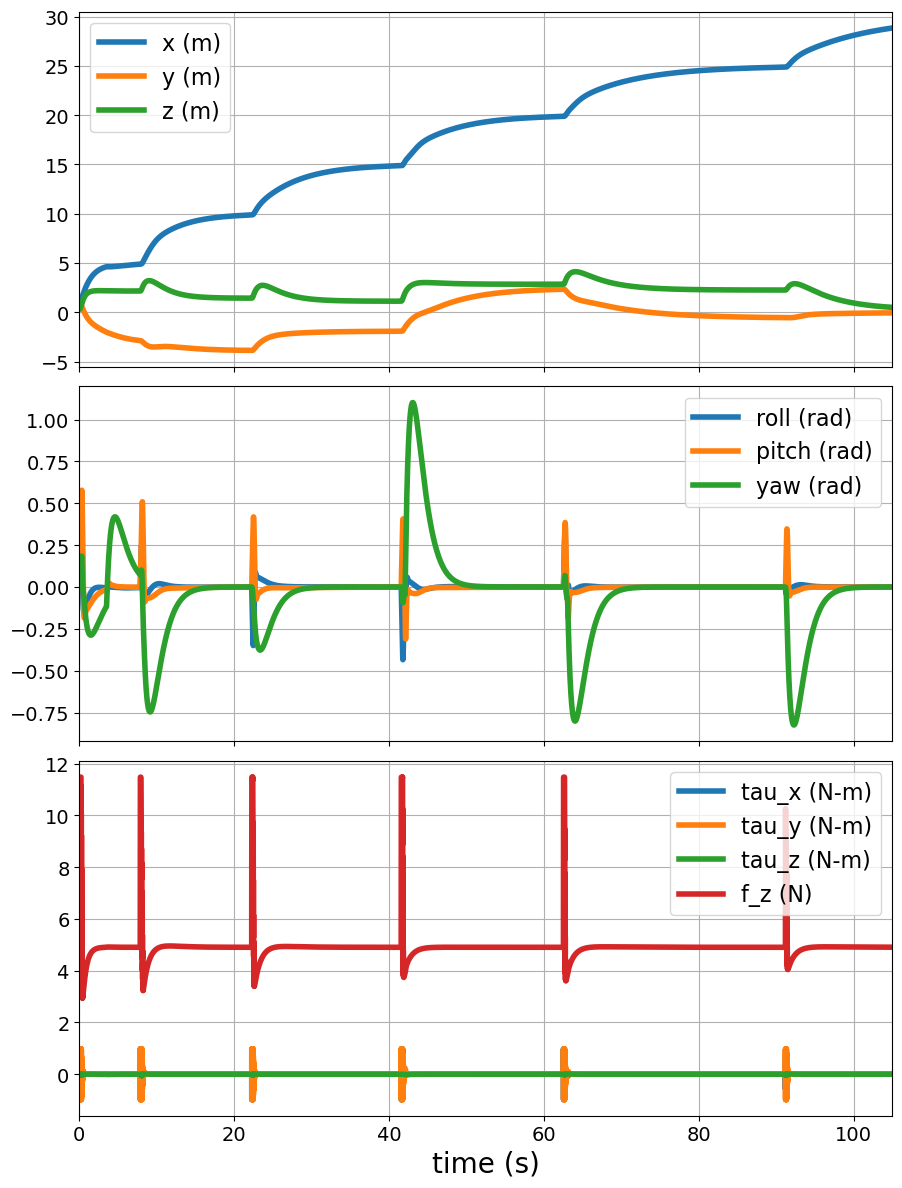

In [24]:
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'][0, :], label='tau_x (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['user_data']['tau_x_des'][0, :], '--', label='desired tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'][0, :], label='tau_y (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['user_data']['tau_y_des'], '--', label='desired tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'][0, :], label='tau_z (N-m)', linewidth=4)
# ax_act.plot(data['t'], data['user_data']['tau_z_des'], '--', label='desired tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'][0, :], label='f_z (N)', linewidth=4)
# ax_act.plot(data['t'], data['user_data']['f_z_des'], '--', label='desired f_z (N-m)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [25]:
data['tau_x'].size

10498

# Additional Code Snippets

### The following code may not be useful if you are not participating in the contests and you can delete it from your notebook

The following sections provide code snippets for doing different things, including making videos, rearranging the rings, loading controllers from the `students` folder to test your collision avoidance code, etc. 

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to show results, change views, keep running

Show results (so far).

In [ ]:
simulator.show_results()

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [25]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Show results (so far).

In [ ]:
simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

You must install both [imageio](https://urldefense.com/v3/__https://github.com/imageio/imageio__;!!DZ3fjg!5XPoUbh51ZMkI_gcRfXcJEw7RMzlJqUwz0wfEMuiObKc8j5eQBZw_AzuIZa4qI6IPrj9qupUf9By72ma9kHEe-GnJ-QYlg$ ) and [imageio-ffmpeg](https://urldefense.com/v3/__https://github.com/imageio/imageio-ffmpeg__;!!DZ3fjg!5XPoUbh51ZMkI_gcRfXcJEw7RMzlJqUwz0wfEMuiObKc8j5eQBZw_AzuIZa4qI6IPrj9qupUf9By72ma9kHEe-FJfhXtNA$ ) in order for this to work. You can do this from a terminal (in your `ae353-bullet` environment, for example) as follows:

```
pip install imageio
pip install imageio-ffmpeg
```

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [ ]:
simulator.run(max_time=1.0, video_filename='my_video.mp4')

In [52]:
from sympy.physics import mechanics
mechanics.init_vprinting()

In [53]:
print(f'{mechanics.mlatex(f)}')

\left[\begin{matrix}v_{x}\\v_{y}\\v_{z}\\\frac{w_{x} \cos{\left(\psi \right)} - w_{y} \sin{\left(\psi \right)}}{\cos{\left(\theta \right)}}\\w_{x} \sin{\left(\psi \right)} + w_{y} \cos{\left(\psi \right)}\\- w_{x} \cos{\left(\psi \right)} \tan{\left(\theta \right)} + w_{y} \sin{\left(\psi \right)} \tan{\left(\theta \right)} + w_{z}\\2 f_{z} \sin{\left(\theta \right)}\\- 2 f_{z} \sin{\left(\phi \right)} \cos{\left(\theta \right)}\\2 f_{z} \cos{\left(\phi \right)} \cos{\left(\theta \right)} - \frac{981}{100}\\\frac{10000 \tau_{x}}{23} - \frac{17 w_{y} w_{z}}{23}\\\frac{10000 \tau_{y}}{23} + \frac{17 w_{x} w_{z}}{23}\\250 \tau_{z}\end{matrix}\right]


In [29]:
print(f'{sym.latex(Q)}')

\mathtt{\text{[[40000     0     0     0     0     0     0     0     0     0     0     0]
 [    0 60000     0     0     0     0     0     0     0     0     0     0]
 [    0     0 60000     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0]
 [    0     0     0     0     0     1     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     0     0     0     0     0]
 [    0     0     0     0     0     0     0     1     0     0     0     0]
 [    0     0     0     0     0     0     0     0     1     0     0     0]
 [    0     0     0     0     0     0     0     0     0     1     0     0]
 [    0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1]]}}


In [37]:
lol = sym.Matrix(R1)
print(f'{mechanics.mlatex(lol)}')

\left[\begin{array}{cccccccccccc}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{array}\right]


In [45]:
print(f'{mechanics.mlatex(B)}')

\left[\begin{matrix}0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 2 \sin{\left(\theta \right)}\\0 & 0 & 0 & - 2 \sin{\left(\phi \right)} \cos{\left(\theta \right)}\\0 & 0 & 0 & 2 \cos{\left(\phi \right)} \cos{\left(\theta \right)}\\\frac{10000}{23} & 0 & 0 & 0\\0 & \frac{10000}{23} & 0 & 0\\0 & 0 & 250 & 0\end{matrix}\right]


In [46]:
print(f'{mechanics.mlatex(C)}')

\left[\begin{array}{cccccccccccc}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\end{array}\right]


In [47]:
print(f'{mechanics.mlatex(K)}')

\mathtt{\text{[[-2.23061647e-13 -1.09544512e+02  1.64045957e-13  1.28147708e+01
  -2.42936225e-14  8.29889745e-16 -2.90077562e-14 -1.69232170e+01
   7.27179621e-15  5.08869282e-01  9.58018218e-18 -1.61602659e-17]
 [ 8.94427191e+01  8.53494115e-14  1.84928850e-15  1.09757428e-15
   1.19301262e+01 -1.86094743e-16  1.47562176e+01  1.11416237e-14
   3.99919753e-16  9.58018218e-18  5.04855009e-01  3.23838910e-17]
 [ 1.73384519e-13  6.51538895e-14  1.87132869e-14 -5.74575157e-15
   5.87695620e-15  4.47213595e-01  2.58438454e-14  1.01513677e-14
   2.35389562e-15 -9.29215291e-18  1.86207373e-17  4.51195865e-01]
 [ 4.02523842e-14 -1.62788713e-13  1.54919334e+02  5.07837218e-15
   3.73107741e-15  4.47840680e-16  6.16209901e-15 -1.12814669e-14
   1.24627178e+01  6.69005251e-17  3.67926173e-18  3.76623299e-17]]}}


In [48]:
print(f'{mechanics.mlatex(Q)}')

NameError: name 'mechanics' is not defined

In [49]:
print(f'{mechanics.mlatex(Q)}')

\mathtt{\text{[[40000     0     0     0     0     0     0     0     0     0     0     0]
 [    0 60000     0     0     0     0     0     0     0     0     0     0]
 [    0     0 60000     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0]
 [    0     0     0     0     0     1     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     0     0     0     0     0]
 [    0     0     0     0     0     0     0     1     0     0     0     0]
 [    0     0     0     0     0     0     0     0     1     0     0     0]
 [    0     0     0     0     0     0     0     0     0     1     0     0]
 [    0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1]]}}


In [50]:
print(f'{mechanics.mlatex(R)}')

\mathtt{\text{[[5.  0.  0.  0. ]
 [0.  5.  0.  0. ]
 [0.  0.  5.  0. ]
 [0.  0.  0.  2.5]]}}
